In [9]:
import cv2
import pandas as pd
import numpy as np
import csv
import platform
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
# sns.set_style("whitegrid", {'axes.grid' : False})



# Behavioral Cloning Data Exploration
This notebook is used to explore the data used to train my behavioral cloning model for a self-driving car

In [10]:
folder_path = '/home/mikedef/udacity/udacity-self-driving-car/CarND-Behavioral-Cloning-P3/data/driving_log.csv'
img_path = '/home/mikedef/udacity/udacity-self-driving-car/CarND-Behavioral-Cloning-P3/behavioral-cloning-submission/'

In [11]:
folder_path

'/home/mikedef/udacity/udacity-self-driving-car/CarND-Behavioral-Cloning-P3/data/driving_log.csv'

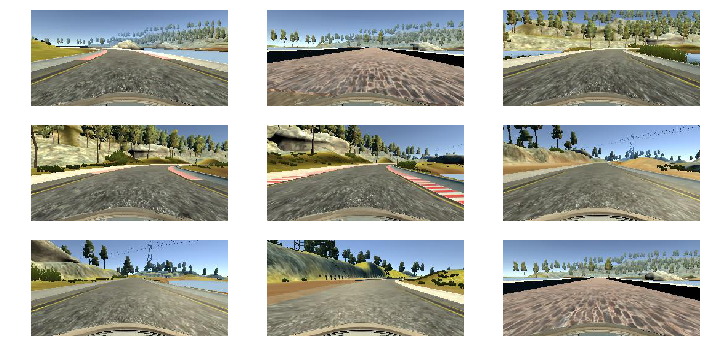

In [12]:
# Observing a few randomly selected images

S = np.ones((9,160,320,3), dtype=np.uint8)
plt.rcParams['figure.figsize'] = (12, 6)

for i in range(9):
    image = mpimg.imread(img_path + "ex_%d.jpg" % i)
    S[i] = image
    plt.subplot(3, 3, i+1)
    plt.imshow(image, aspect='auto')
    plt.axis('off')

# Observations 1:
    1. Hood of the car is visible at the bottom of the image
    2. Above the horizon line is not useful data as this is where the road ends. 

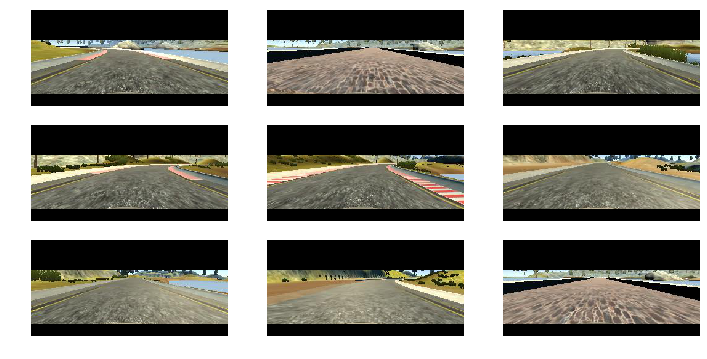

In [13]:
# Croping off top 50 pixels and bottom 20 pixels of the image to remove the hood of the car and the horizon

bottom_shave_pixels = 20
top_shave_pixels = 50

bonnet_pixels_start = 160 - bottom_shave_pixels
for i in range(9):
    S[i,bonnet_pixels_start:,:,:] = 0
    S[i,:top_shave_pixels,:,:] = 0
    image = S[i]
    plt.subplot(3, 3, i+1)
    plt.imshow(image, aspect='auto')
    plt.axis('off')

# Observations 2:
    1. The images are much better suited now.
    2. Pixels are reduced 

# Exploring driving_log.csv

In [14]:
import pandas as pd

data_frame = pd.read_csv('data/driving_log.csv', usecols=[0,1,2,3])

data_frame.describe(include='all')

,center,left,right,steering
count,22599,22599,22599,22599.000000
unique,22599,22599,22599,NaN
top,/home/mikedef/udacity/udacity-self-driving-car...,/home/mikedef/udacity/udacity-self-driving-car...,/home/mikedef/udacity/udacity-self-driving-car...,NaN
freq,1,1,1,NaN
mean,NaN,NaN,NaN,-0.006556
std,NaN,NaN,NaN,0.229997
min,NaN,NaN,NaN,-1.000000
25%,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,0.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6738e4940>]], dtype=object)

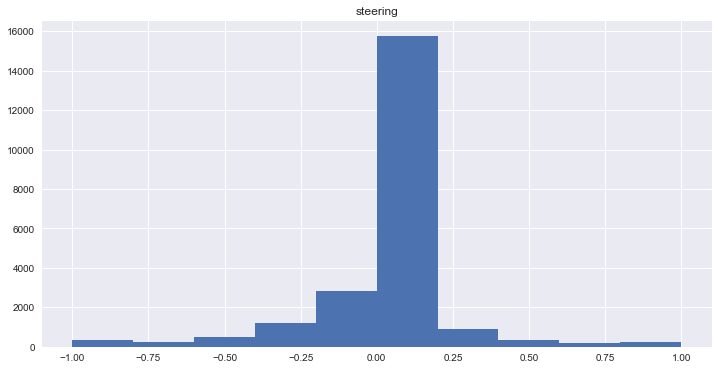

In [15]:
data_frame.hist(column='steering')

Using TensorFlow backend.


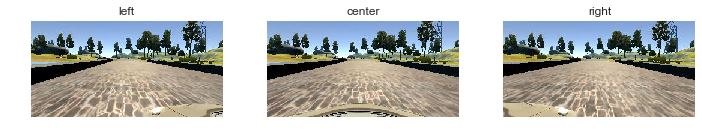

In [16]:
from keras.preprocessing.image import img_to_array, load_img

i = 0
for camera in ['left', 'center', 'right']:
    image = load_img("data/"+data_frame.iloc[0][camera].strip())
    image = img_to_array(image).astype(np.uint8)
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(camera)
    i += 1

# Observations 3:
    1. The data set contains 22599 rows
    2. Most of the steering angles are close to zero on the negative side
    3. The left and right cameras point straight, along the length of the car. So the left and right camera are like parallel transformations of the car

# Conclusions:
    1. The size of the image can be reduced by half by ignoring the non-usefull portions of the image.
    2. The images can be flipped horizontally (and invert the corresponding steering angle), so that we can reduce the bias for turing left.
    3. We can incorporate the left & right camera images to simulate recovery, when the steering anlge is close to zero.


# Augmentation Techniques
## Use left & right camera images to simulate recovery

Using left and right camera images to simulate the effect of car wandering off to the side, and recovering. We will add a small angle .25 to the left camera and subtract a small angle of 0.25 from the right camera. The main idea being the left camera has to move right to get to center, and right camera has to move left.

## Flip the images horizontally¶

Since the dataset has a lot more images with the car turning left than right(because there are more left turns in the track), you can flip the image horizontally to simulate turing right and also reverse the corressponding steering angle.

## Brightness Adjustment (Not currently used)

In this you adjust the brightness of the image to simulate driving in different lighting conditions

## Add Random Shadows¶( Not currently used)

Although not demonstrated in the notebook, you can see an illustration of this method in the above mentioned blog post.

With these augmentation techniques, you can practically generate infinite unique images for training your neural network.

In [17]:
import cv2

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

TARGET_SIZE = (64,64)

# def resize_to_target_size(image):
#     return cv2.resize(image, TARGET_SIZE) 
    
# def crop_and_resize(image):
#     cropped_image = image[55:135,:,:]
#     processed_image = resize_to_target_size(cropped_image)
#     return processed_image

def flip_image(image):
    return cv2.flip(image, 1)

def preprocess_image(image):
    image = crop_and_resize(image)
    image = image.astype(np.float32)
    image = image/255.0 - 0.5
    return image

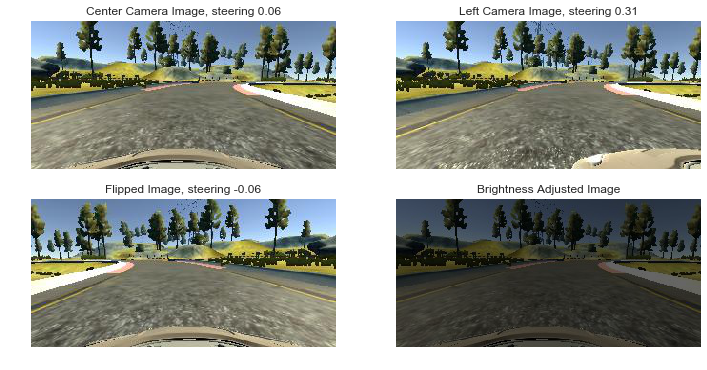

In [29]:


row = data_frame.iloc[2500]
steering = row['steering']
image = load_img("data/"+row["center"].strip())
image = img_to_array(image).astype(np.uint8)

plt.subplot(2,2,1)
plt.imshow(image, aspect='auto')
plt.axis('off')
plt.title("Center Camera Image, steering %.2f" % steering)

left = load_img("data/"+row["left"].strip())
left = img_to_array(left).astype(np.uint8)

plt.subplot(2,2,2)
plt.imshow(left, aspect='auto')
plt.axis('off')
plt.title("Left Camera Image, steering %.2f" % (steering + 0.25))

plt.subplot(2,2,3)
plt.imshow(flip_image(image), aspect='auto')
plt.axis('off')
plt.title("Flipped Image, steering %.2f" % (-1.0*steering))

plt.subplot(2,2,4)
plt.imshow(augment_brightness_camera_images(image), aspect='auto')
plt.axis('off')
plt.title("Brightness Adjusted Image")

mpimg.imsave(("Center Camera Image, steering %.2f" % steering + '.png'), image)
mpimg.imsave(("Left Camera Image, steering %.2f" % (steering + 0.25) + '.png'), left)
mpimg.imsave(("Flipped Image, steering %.2f" % (-1.0*steering) + '.png'), flip_image(image))
mpimg.imsave(("Brightness Adjusted Image" + '.png'), augment_brightness_camera_images(image))